In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
import random as rn
import seaborn as sns
import random
import ast

In [2]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]


(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [3]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [4]:
df.speech = df.speech.apply(lambda x: x.replace(".", " . ")) #add space around dot
df.speech = df.speech+' . '

#concat sentences, each last sentence for each speech did not have dot so add one.
print('Preparing data...')
'''
cade tool uses gensim.models.word2vec.LineSentence() to iterate over the training corpus
gensim.models.word2vec.LineSentence() takes as input 
a file that contains sentences: one line = one sentence.
Words must be already preprocessed and separated by whitespace'''
df.speech = df.speech.apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.apply(lambda x: re.sub('\s\s+' , ' ', x)) 
df.speech = df.speech.apply(lambda x: x.replace('. ', '.\n'))

df = df.rename(columns={'parliamentary_period': 'period'})

# Adjust period names, merge small periods with larger and remove words in order to easily sort later on
df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))
df.period = df.period.astype(int)
df.loc[(df.period==5), 'period'] = 7
df.loc[(df.period==6), 'period'] = 7
df.loc[(df.period==14), 'period'] = 15 #2012-2014
df.loc[(df.period==16), 'period'] = 17 #2015-2019

print('Group by periods...')
print(datetime.datetime.now())
PERperiod_df = df.groupby(df.period)['speech'].apply(''.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


Preparing data...
Group by periods...
2021-12-13 00:28:58.923511


In [5]:
# print(PERperiod_df)
# PERperiod_df.speech = PERperiod_df.speech.str[:30000]
# print(len(PERperiod_df.speech.iloc[0]))

Create file per year

In [6]:
training_texts_dir = 'training_texts/PERperiod/'
if not os.path.exists(training_texts_dir):
    os.makedirs(training_texts_dir)

for period, speech in zip(PERperiod_df.period, PERperiod_df.speech):
#     print(year)
    with open(training_texts_dir+str(period)+'.txt', "w") as o:
        o.write(speech)      

In [7]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

In [8]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'drain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια', 'υιοθεσιας',
          'εθνικη', 'αμυνα', 'ενοπλες',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 'φορολογια',
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'ασυλου', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ', 'αστυνομικη', 'αστυνομικοι', 'αστυνομικων',
          'προσφυγικο', 'μεταναστευτικο', 'προσφυγες', 'μεταναστες',
          'τουρισμος', 'τουριστικης', 'τουρισμου', 'τουρισμο',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', 'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'μακεδονικο', 'μακεδονιας', 'μακεδονια', 'προσληψεις', 'απολυσεις', 'εκας', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο',
                     'θρησκεια', 'θρησκειας', 'θρησκευτικο', 'θρησκευτικων', 'γυναικα', 'γυναικας', 'ανδρας', 'ανδρα', 'αντρας', 'αντρα', 'ομοφυλα', 'ομοφυλοφιλοι', 'ομοφιλοφιλων', 'εοπυυ', 'τουρκια', 'τουρκιας', 'εκκλησιας', 'εκκλησια', 'κριση', 'κρισης', 'αυθαιρεσια',
                     
         ]

Method takes as input models and topics and computes 2nd order similarity

In [8]:
def neighbor_2nd_order_cosine(m1, m2, vouliwatch_topics, similarities_2nd_order):
    
    for topic in vouliwatch_topics:

        if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):

            #union of neighbors in two points in time
            neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

            neighbors_union=[]
            # keep neighbors that are included in the compared model vocabularies
            for neighbor in neighbors_t1_t2:
                if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
                    neighbors_union.append(neighbor)
        #     print('Union of neighbors: ', str(len(neighbors_union)))

            # similarity vector for time point 1 (t1)
            # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
            similarity_vector_t1 = []
            topic_vector_t1 = m1.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m1.wv[nn]
                similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t1))

            # similarity vector for time point 2 (t2)
            # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
            similarity_vector_t2 = []
            topic_vector_t2 = m2.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m2.wv[nn]
                similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t2))


            # final cosine between cosines/ similarity vectors for t1 and t2
            result = cosine_similarity(np.array([similarity_vector_t1]),
                                       np.array([similarity_vector_t2])
                                      )[0][0]

            similarities_2nd_order.append([topic, pair, result, len(neighbors_union), neighbors_t1, neighbors_t2])

            
        else:
            print(topic, ' not in vocabulary for years ', str(pair))

    return similarities_2nd_order


In [9]:
#sort dataframe by period
periods = sorted(PERperiod_df.period.to_list())
period_pairs = step_one_pairs(periods)

print(period_pairs)
# for pair in period_pairs:
#     print(type(pair[0]))

[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]


In [57]:
np.random.seed(5)
rn.seed(5)
my_seed = 5

# similarities_2nd_order = []
shifts_pp_list = []

for pair in period_pairs:
    period_1, period_2 = str(pair[0]),str(pair[1])
    print(pair)
    compass_file_path = training_texts_dir+str(period_1)+'.'+str(period_2)+'.txt'
    with open(compass_file_path, "w") as o:
        o.write(open(training_texts_dir+period_1+'.txt').read()+"\n"+open(training_texts_dir+period_2+'.txt').read())
    
    aligner = CADE(size=300, workers=1)
    aligner.train_compass(compass_file_path, overwrite=True, save=True, seed=my_seed)
    m1 = aligner.train_slice(training_texts_dir+period_1+'.txt', save=True, seed=my_seed)
    m2 = aligner.train_slice(training_texts_dir+period_2+'.txt', save=True, seed=my_seed)
    
    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))

    for topic in vouliwatch_topics:
        if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):
            cos_sim = compute_cosine_similarity(m1, m2, topic)
            most_similar_words_period0 = m1.wv.most_similar(positive=[topic], topn=20)
            most_similar_words_period1 = m2.wv.most_similar(positive=[topic], topn=20)
            shifts_pp_list.append([pair, topic, cos_sim, len(common_vocab),
                                   most_similar_words_period0, most_similar_words_period1])

            
#     similarities_2nd_order = neighbor_2nd_order_cosine(m1, m2, vouliwatch_topics, similarities_2nd_order)


shifts_pp_df = pd.DataFrame(shifts_pp_list, columns = ['period_pair', 'word', 
                                                     'semantic_similarity', 'common_voc_size',
                                                        'neighbors_t1',
                                                        'neighbors_t2'])

shifts_pp_df = shifts_pp_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(shifts_pp_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(shifts_pp_df.tail(20))
shifts_pp_df.to_csv('../out_files/selected_topics_shift_per_period_compass.csv', 
                           index=False)



[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]
(7, 8)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/7.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/8.txt.
Initializing embeddings from compass.
(8, 9)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/8.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/9.txt.
Initializing embeddings from compass.
(9, 10)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/9.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/10.txt.
Initializing embeddings from compass.
(10, 11)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/10.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/11.txt.
Initializing embeddings from compass.
(11, 12)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/11.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/12.txt.
Initializing embeddings from compass.
(12, 13)
Training the compass from scratch.
Current saved compass will be overwritten after training


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/12.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/13.txt.
Initializing embeddings from compass.
(13, 15)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/13.txt.
Initializing embeddings from compass.


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

Training embeddings: slice training_texts/PERperiod/15.txt.
Initializing embeddings from compass.
(15, 17)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/15.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/17.txt.
Initializing embeddings from compass.
(17, 18)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/PERperiod/17.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/PERperiod/18.txt.
Initializing embeddings from compass.
Words with the lowest cosine similarity / highest change
  period_pair    word  semantic_similarity  common_voc_size  \
0    (12, 13)  εθνικη             0.998592               79   

                                        neighbors_t1  \
0  [(@sw, 0.9998704195022583), (πατριδα, 0.999852...   

           

/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See 

In [58]:
# df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'year_pair', 'cosine_similarity', 'neighbors_union', 'neighbors_t1', 'neighbors_t2'])

# df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
# print(df_similarities_2nd_order.head(5))
# df_similarities_2nd_order.describe()
# !pwd
# df_similarities_2nd_order = df_similarities_2nd_order.sort_values(by='year_pair')
# df_similarities_2nd_order.to_csv('../../out_files/selected_topics_cultural_shift_per_year_with_compass.csv', index=False)
# df_similarities_2nd_order = pd.read_csv('../../out_files/selected_topics_cultural_shift_per_year_with_compass.csv')
# print(df_similarities_2nd_order)

# Present results

In [10]:
shifts_pp_df = pd.read_csv('../out_files/selected_topics_shift_per_period_compass.csv',
                           #selected_topics_shift_per_period_compass
                          converters={'period_pair':ast.literal_eval})
print(set(shifts_pp_df.word.to_list()))


{'αστυνομια', 'εκκλησια', 'αντρας', 'ενεργεια', 'υιοθεσια', 'υγεια', 'επενδυσεις', 'εξωτερικη', 'οαεδ', 'τουριστικης', 'θρησκειας', 'αστυνομικη', 'γυναικας', 'ανδρας', 'εργασια', 'δικαιοσυνη', 'αναπλαση', 'επιδοματα', 'προσχολικη', 'αυθαιρεσια', 'θρησκευτικων', 'αγροτικα', 'επιχειρησεις', 'εργασιακα', 'αμυνα', 'δευτεροβαθμια', 'μακεδονια', 'τουρισμο', 'συνταξη', 'εθνικη', 'πρωτοβαθμια', 'διαφανεια', 'δημοσια', 'απολυσεις', 'πανεπιστημιακο', 'επενδυσεων', 'αγροτικη', 'εκκλησιας', 'αφορολογητο', 'τουρισμου', 'συλλογικη', 'νομοσχεδιο', 'προνοια', 'αντρα', 'εοπυυ', 'ομοφυλα', 'μακεδονιας', 'οικονομια', 'φπα', 'ερευνα', 'αναπτυξη', 'drain', 'ενοπλες', 'μεταναστες', 'brain', 'βασικος', 'ανωτατη', 'προσληψεις', 'μισθος', 'αθλητισμος', 'αθλητισμου', 'δικαιωματα', 'επιδοματων', 'ανδρα', 'γυναικα', 'φορολογικα', 'μειωση', 'πολιτισμο', 'υποδομες', 'αστυνομικοι', 'συμβαση', 'μακεδονικο', 'θρησκεια', 'οσε', 'αυξηση', 'τουρκια', 'προστασια', 'υδροδοτηση', 'αλιεια', 'επιδομα', 'μεταναστευτικο', 'ομοφ

In [16]:
def translate_word(word):
    
    
    lookup = {'αγροτικη':'agricultural', 'αγροτικα':'agricultural', 'αγροτες':'farmers', 
          'αναπτυξη':'growth', 'επενδυσεις':'investements', 'επενδυσεων':'investements',
          'ασφαλιστικο':'insurance', 'εργασια':'labor', 'εργασιακα':'labor', 'δικαιωματα':'rights', 'συμβαση':'contract', 'συλλογικη':'collective', 'μισθος':'salary', 'βασικος':'minimum', 'ημιαπασχοληση':'part-time', 'brain':'brain', 'drain':'drain', 'οαεδ':'OAED',
          'δικαιοσυνη':'justice', 'διαφανεια':'transparency', 'υιοθεσια':'adoption', 'υιοθεσιας':'adoption',
          'εθνικη':'national', 'αμυνα':'defence', 'ενοπλες':'armed',
          'εξωτερικη':'foreign', 'διεθνεις':'international',
          'ναυτιλια':'shipping','νησια':'islands','υδροδοτηση':'water_supply','αλιεια':'fishing',
          'οικονομια':'economy', 'αφορολογητο':'tax-exempt', 'αποκεντρωση':'decentralization', 'φπα':'VAT', 'επιχειρησεις':'businesses', 'φορολογικα':'tax', 'φορολογια':'taxation',
          'παιδεια':'education', 'ερευνα':'research', 'προσχολικη':'preschool', 'ασυλο':'asylum', 'ασυλου':'asylum', 'πανεπιστημιακο':'university', 'δευτεροβαθμια':'secondary', 'πρωτοβαθμια':'primary', 'ανωτατη':'higher', 'δημοσια':'public', 'ιδιωτικη':'private', 'σχολες':'schools/faculties',
          'περιβαλλον':'environment', 'ενεργεια':'energy', 
          'συστημα':'system',
          'πολιτισμος':'culture', 'αθλητισμος':'sports', 'πολιτισμο':'culture', 'αθλητισμου':'sports',
          'προστασια':'protection', 'αστυνομια':'police', 'κοκ':'traffic_code', 'αστυνομικη':'police', 'αστυνομικοι':'police', 'αστυνομικων':'police', 
          'προσφυγικο':'refugee', 'μεταναστευτικο':'migratory', 'προσφυγες':'refugees', 'μεταναστες':'immigrants',
          'τουρισμος':'tourism', 'τουριστικης':'tourism', 'τουρισμου':'tourism', 'τουρισμο':'tourism',
          'υγεια':'heatlh', 'προνοια':'welfare', 'επιδοματα':'subsidies', 'επιδομα':'subsidy', 'επιδοματων':'subsidies',
          'υποδομες':'infrastructure', 'μεταφορες':'transportation', 'αναπλαση':'remodeling', 'μμμ':'public_transport ',
          'μειωση':'reduction', 'αυξηση':'raise', 'συνταξη':'retirement', 'μακεδονια':'macedonia', 'μακεδονιας':'macedonia', 'μακεδονικο':'macedonian', 'προσληψεις':'hirings', 'απολυσεις':'redundancies', 'εκας':'EKAS', 'οσε':'OSE', 'συγκοινωνιες':'transportation', 'νομοσχεδιο':'bill',
                     'θρησκεια':'religion', 'θρησκειας':'religion', 'θρησκευτικο':'religious', 'θρησκευτικου':'religious', 'θρησκευτικων':'religious', 'γυναικα':'woman', 'γυναικας':'woman', 'ανδρας':'man','αντρας':'man','αντρα':'man','ανδρα':'man', 'ομοφυλα':'same-sex', 'ομοφυλοφιλοι':'homosexuals', 'ομοφιλοφιλων':'homosexuals',
                      'εοπυυ':'EOPPY', 'τουρκια':'Turkey', 'τουρκιας':'Turkey', 'εκκλησιας':'church', 'εκκλησια':'church', 'κριση':'crisis', 'κρισης':'crisis', 'αυθαιρεσια':'arbitrariness'}
    
    if word in lookup.keys():
        return lookup[word]
    return word



def periods_to_dates(period_pair):
    
    period_dict = {5:[1989],
                  6:[1989, 1990],
                  7:[1990, 1993],
                  8:[1993, 1996],
                  9:[1996, 2000],
                  10:[2000, 2004],
                  11:[2004, 2007],
                  12:[2007, 2009],
                  13:[2009, 2012],
                  14:[2012], 
                  15:[2012, 2014], 
                  16:[2015],
                  17:[2015, 2019], 
                  18:[2019, 2020]}
    
    super_periods = {7:[5,6,7], 15:[14,15], 17:[16,17]}
    
    new_periods = []
    new_dates = []
    
    for period in period_pair:
        if period in super_periods.keys():
            new_periods.append('-'.join([str(p) for p in super_periods[period]])) #5-6-7
            new_dates.append((period_dict[super_periods[period][0]][0], period_dict[super_periods[period][-1]][-1]))
        else:
            new_periods.append(period)
            new_dates.append(period_dict[period])
        
#     new_period_pair = 'vs '.join([str(p) for p in new_periods])
#     new_date_range = '('+'-'.join([str(d1) for d1 in new_dates[0]])+',\n'+'-'.join([str(d2) for d2 in new_dates[1]])+ ')'
    out = str(new_periods[0])+' ('+'-'.join([str(d1) for d1 in new_dates[0]])+') &\n'+(str(new_periods[1]))+' ('+'-'.join([str(d2) for d2 in new_dates[1]])+')'
#     new_period_pair = 'vs '.join([str(p) for p in new_periods])
#     new_date_range = '('+'-'.join([str(d1) for d1 in new_dates[0]])+',\n'+'-'.join([str(d2) for d2 in new_dates[1]])+ ')'
    #     out = new_period_pair+'\n'+new_date_range
    
    return(out)

def plot_swift(vouliwatch_topics, shifts_pp_df):
    
    most_changed_topics = []
    
    colors = sns.color_palette('colorblind').as_hex()
    # colors+=list(np.repeat(colors, neighbors_No))
    plt.figure(figsize=(18, 10))
    
    for topic in vouliwatch_topics:
        topic_subdf = shifts_pp_df.loc[(shifts_pp_df.word==topic)]
        
        if topic_subdf.shape[0]>0:
            
            topic_subdf = topic_subdf.sort_values('period_pair')
            period_pairs = topic_subdf.period_pair.to_list()
            X = [(pair[0]+pair[1])/2 for pair in period_pairs]
            Y = topic_subdf.semantic_similarity.to_list()
            #print(Y)
            consecutive_diffs = topic_subdf.semantic_similarity.diff().to_list()
#             print()
            avg_change = sum(topic_subdf.semantic_similarity.to_list())/topic_subdf.shape[0]
#             print(avg_change)
            
            if (any(abs(n)>0.25 for n in consecutive_diffs[1:]) or (
                not all(sim >= 0.65 for sim in Y))) and topic not in ['προσχολικη',
                                                                      'κοκ',
                                                                      'οσε',
                                                                      'αθλητισμος',
                                                                      'αθλητισμου',
                                                                      'υδροδοτηση',
                                                                      'θρησκευτικων', 'θρησκειας', 'θρησκευτικα', 'θρησκευτικο',# keep θρησκει
                                                                      'ανδρα', 'αντρας', 'αντρα', #keep ανδρας
                                                                      'οαεδ',
                                                                      'υιοθεσιας', #keep υιοθεσια
                                                                      'αλιεια',
                                                                      'εργασιακα',
                                                                      'εκκλησιας', 'εκκλησια',
                                                                      'γυναικας'] or topic in ['γυναικα']:
#                 if topic in ['αυθαιρεσια', 'αστυνομικη']:
                if True:
            
#                 print(consecutive_diffs)
            
        
#             if (not all(sim>=(avg_change-0.1) for sim in Y)):
#            plot only those that go below 0.5

#             if (not all(sim >= 0.7 for sim in Y)) and topic not in ['προσχολικη', 'κοκ',
#                                                                     'οσε', 'αθλητισμος', 'αθλητισμου',
#                                                                     'υδροδοτηση', 'ανδρα',#'ανδρας', 'αντρας', 'αντρα',
#                                                                     'οαεδ', 'αλιεια', 'εργασιακα',
#                                                                     'εκκλησιας']:

                    most_changed_topics.append(topic)
                    plt.scatter(X,Y)
                    plt.plot(X,Y, label=translate_word(topic)) # 

                    #annotate with topic name the lower point
                    min_sim_index = Y.index(min(Y))

    #                 add_x = (random.uniform(-0.5,0.5))
    #                 add_y = (random.uniform(-0.045,-0.02))
                    add_y = -0.06

                    plt.annotate(text=translate_word(topic), # translate_word(topic)
                               xy=(X[min_sim_index],Y[min_sim_index]),
                                 xytext=(X[min_sim_index]+add_y, Y[min_sim_index]+add_y),
                                 arrowprops=dict(arrowstyle="->"),
                                 size=16
                               )


    middle_periods = [(pair[0]+pair[1])/2 for pair in step_one_pairs(periods)]
    x_labels = [periods_to_dates(pair) for pair in step_one_pairs(periods)]

    plt.xticks(middle_periods,x_labels, rotation=70, fontsize=16)
    plt.yticks(fontsize=18)
    plt.legend(ncol=3, fontsize=18) #bbox_to_anchor=(1, 1),
#     plt.rcParams['figure.figsize'] = (15, 5)
    plt.rcParams['axes.labelsize'] = 19
#     ax = plt.gca()
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
#     ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
#     ax.set_xticklabels(fontsize=20)
#     ax.set_yticklabels(fontsize=20)

#     plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.title('Usage Change of Selected Topics Through Time', fontsize=20)
    plt.ylabel('Cosine Similarity', fontsize=20)
    plt.xlabel('Pairs of Parliamentary Periods', fontsize=20)
    plt.savefig('../out_files/selected_topics_shift_per_period_compass.png', dpi=200, bbox_inches='tight')
    plt.show()
    return(most_changed_topics, consecutive_diffs)
    
#     plt.clf()
#     plt.cla()
#     plt.close()
#     fig.canvas.draw_idle()


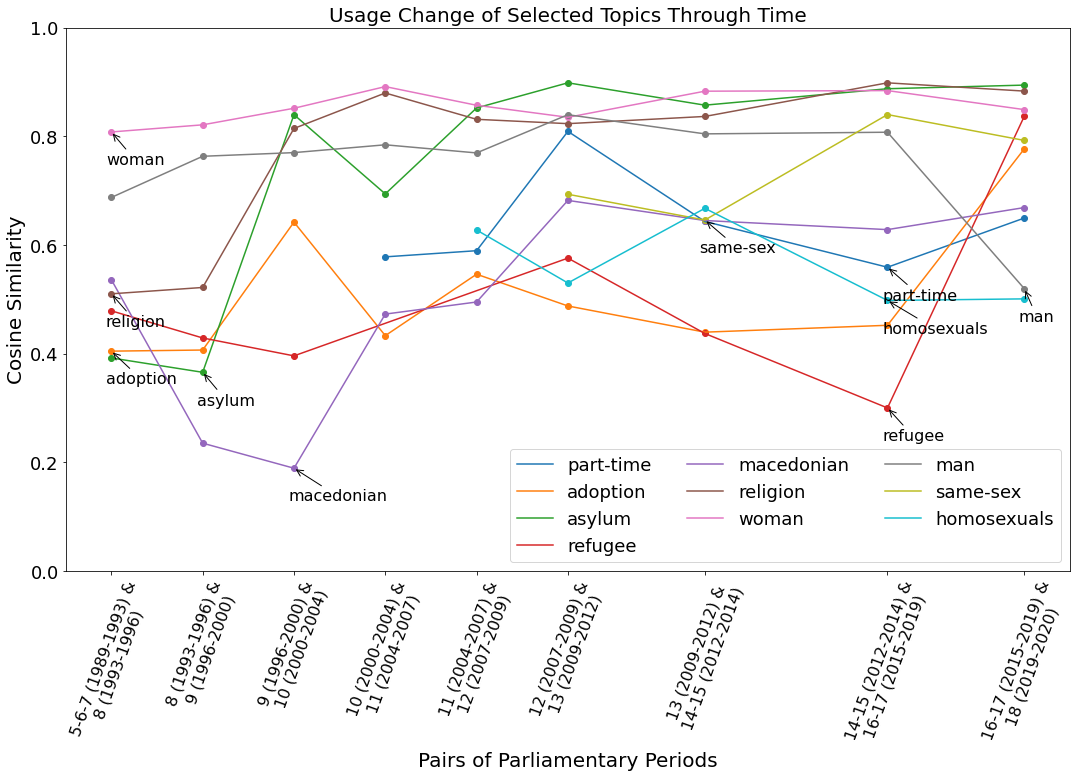

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt

most_changed_topics, consecutive_diffs = plot_swift(vouliwatch_topics, shifts_pp_df)


In [15]:
df = pd.read_csv('../out_files/selected_topics_shift_per_period_compass.csv')
df.columns

Index(['period_pair', 'word', 'semantic_similarity', 'common_voc_size',
       'neighbors_t1', 'neighbors_t2'],
      dtype='object')

In [205]:

for topic in vouliwatch_topics:
    topic_subdf = df.loc[(df.word==topic)]

    if topic_subdf.shape[0]>0 and topic in most_changed_topics:

        topic_subdf = topic_subdf.sort_values('semantic_similarity')
        print(topic_subdf.iloc[0].word)
        print(topic_subdf.iloc[0].period_pair)
        print(topic_subdf.iloc[0].semantic_similarity)
        print(topic_subdf.iloc[0].neighbors_t1)
        print(topic_subdf.iloc[0].neighbors_t2)
        print('---------')

        #         period_pairs = topic_subdf.period_pair.to_list()
#         X = [(pair[0]+pair[1])/2 for pair in period_pairs]
#         Y = topic_subdf.semantic_similarity.to_list()
# #             print(Y)

#         # plot only those that go below 0.5
#         if (not all(sim >= 0.6 for sim in Y)) and topic!='προσχολικη':

#             most_changed_topics.append(topic)
#             plt.scatter(X,Y)
#             plt.plot(X,Y, label=translate_word(topic)) # connect dots

#             #annotate with topic name the lower point
#             min_sim_index = Y.index(min(Y))

# #                 add_x = (random.uniform(-0.5,0.5))
# #                 add_y = (random.uniform(-0.045,-0.02))
#             add_y = -0.06

#             plt.annotate(text=translate_word(topic), 
#                        xy=(X[min_sim_index],Y[min_sim_index]),
#                          xytext=(X[min_sim_index]+add_y, Y[min_sim_index]+add_y),
#                          arrowprops=dict(arrowstyle="->"),
#                          size=16
#                        )



ημιαπασχοληση
(15, 17)
0.5590726
[('επιδοτουμενοι', 0.6843834519386292), ('επιδοτουμενους', 0.6508324146270752), ('τετραμηνα', 0.6196205615997314), ('εναλλασσομενη', 0.619152843952179), ('ανταποκριτες', 0.6094347238540649), ('επανασχεδιαζεται', 0.6083276271820068), ('δασεργατες', 0.600799560546875), ('κακομοιροι', 0.5999670028686523), ('καταλληλοτεροι', 0.599776029586792), ('βρεφονηπιοκομοι', 0.5986366271972656), ('δασοπυροσβεστες', 0.5984863042831421), ('γενικευονται', 0.5950586795806885), ('συγκεκαλυμμενη', 0.5930817127227783), ('μηχανιστικο', 0.5927718877792358), ('1431', 0.591861367225647), ('απεξαρτημενων', 0.5916452407836914), ('ετεροαπασχοληση', 0.5888701677322388), ('εξαφανιζετε', 0.5881702303886414), ('επανασυστησουμε', 0.5871917605400085), ('ανυπομονει', 0.5864732265472412)]
[('υποαπασχοληση', 0.7034820318222046), ('καταπολεμαμε', 0.6797381639480591), ('υψηλοτατη', 0.6400054693222046), ('ασταματητη', 0.6359449625015259), ('εξαιρετη', 0.6253882050514221), ('λυπηθειτε', 0.62202